In [2]:
import numpy as np
from time import time
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import pdspy.modeling as modeling
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.animation import FuncAnimation
import os
import pickle

from ppca import PPCA

%matplotlib inline

### read in grid data

In [9]:
# parameter value lists
T_star = []
logL_star = []
logM_disk = []
logR_disk = []
h_0 = []
logR_in = []
gamma = []
beta = []
logM_env = []
logR_env = []
f_cav = []
ksi = []
loga_max = []
p = []
incl = []

params = [T_star,logL_star,logM_disk,logR_disk,h_0,logR_in,\
          gamma,beta,logM_env,logR_env,f_cav,ksi,loga_max,p,incl]

for i in range(len(params)):
    filename="../grid_metadata/param"+str(i)+".txt"
    with open (filename, 'rb') as fp:
        params[i] = pickle.load(fp) 

# sets - filenames

with open ('../grid_metadata/core518.txt', 'rb') as fp:
    corecomp1 = pickle.load(fp)
with open ('../grid_metadata/core518.txt', 'rb') as fp:
    corecomp2 = pickle.load(fp)
with open ('../grid_metadata/core518.txt', 'rb') as fp:
    corecomp3 = pickle.load(fp)
with open ('../grid_metadata/core518.txt', 'rb') as fp:
    corecomp4 = pickle.load(fp)
with open ('../grid_metadata/core518.txt', 'rb') as fp:
    corecomp5 = pickle.load(fp)

cores=[corecomp1,corecomp2,corecomp3,corecomp4,corecomp5]

# sets - flux values in log space

with open ('../grid_metadata/cube518.txt', 'rb') as fp:
    cubecomp1 = np.array(pickle.load(fp))
with open ('../grid_metadata/cube518.txt', 'rb') as fp:
    cubecomp2 = np.array(pickle.load(fp))
with open ('../grid_metadata/cube518.txt', 'rb') as fp:
    cubecomp3 = np.array(pickle.load(fp))
with open ('../grid_metadata/cube518.txt', 'rb') as fp:
    cubecomp4 = np.array(pickle.load(fp))
with open ('../grid_metadata/cube518.txt', 'rb') as fp:
    cubecomp5 = np.array(pickle.load(fp))
with open ('../grid_metadata/cube518.txt', 'rb') as fp:
    cube = np.array(pickle.load(fp))


cubes=[cubecomp1,cubecomp2,cubecomp3,cubecomp4,cubecomp5]

sizes=[]
for i in range(len(cores)):
    sizes.append(len(cores[i]))
    
sets=np.linspace(0.,1.,len(cores))
colors= plt.cm.viridis(sets)

labels=["20_cut","pl_cut","ppca","nan_cut","40_cut"]
    
# x values (wavelengths) - same 500 values for all sets, normal space
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)   

### deal with -infs from log transform

In [10]:
# horizontal cutoff below -20 to remove -infs
cubes[0][cubes[0]<-20]=-20

# powerlaw cutoff
for i in range(len(cubes[1])):
    if -np.inf in cubes[1][i]:
        a=cubes[1][i].tolist()
        a.reverse()
        ind=len(a)-a.index(-np.inf)
        x1=xvals[ind]
        y1=cubes[1][i][ind]
        for j in range(ind):
            cubes[1][i][j]=(100*(np.log10(xvals[j]/x1)))+y1

# convert to nans
df = pd.DataFrame(cubes[2])
cubes[2] = df.replace(-np.inf,np.nan).values

# nan cutoff
cubes[3][cubes[3]<-20]=np.nan

# horizontal cutoff below -40 to remove -infs
cubes[4][cubes[4]<-40]=-40

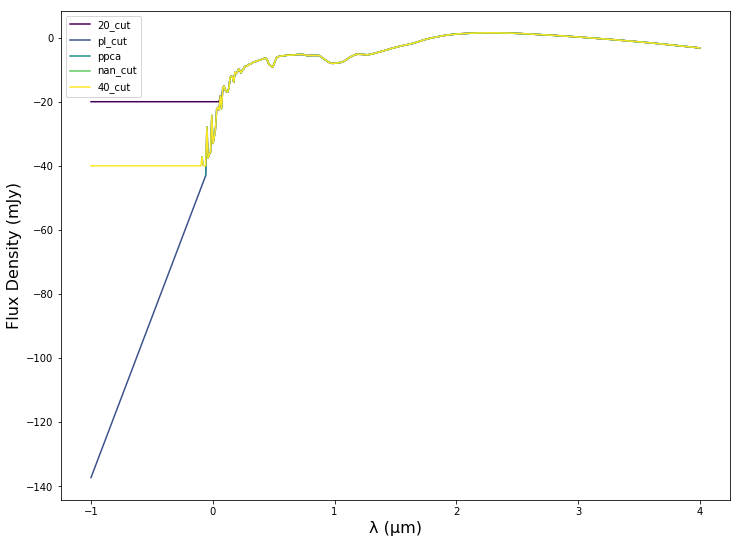

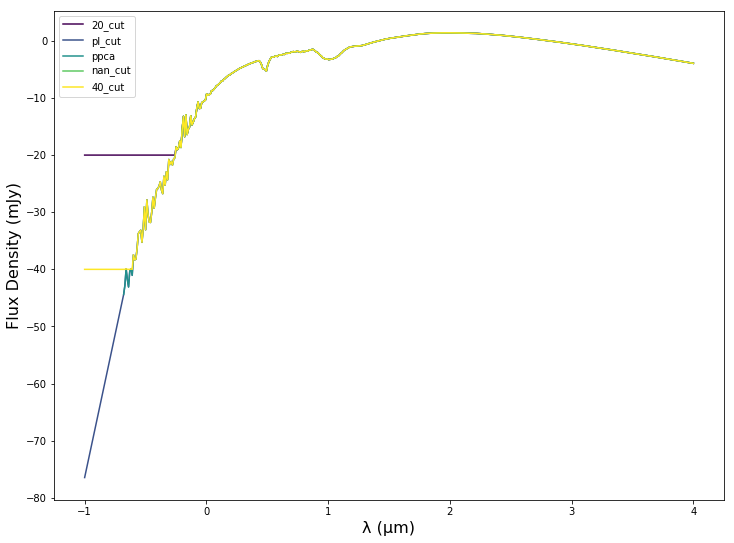

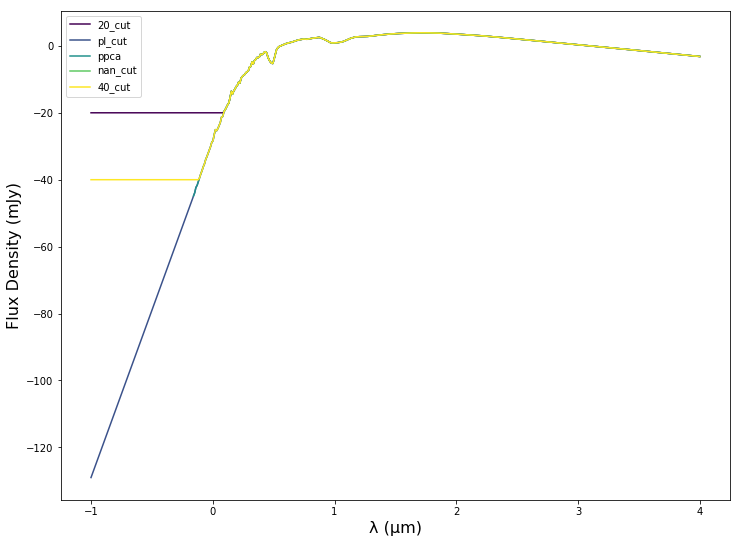

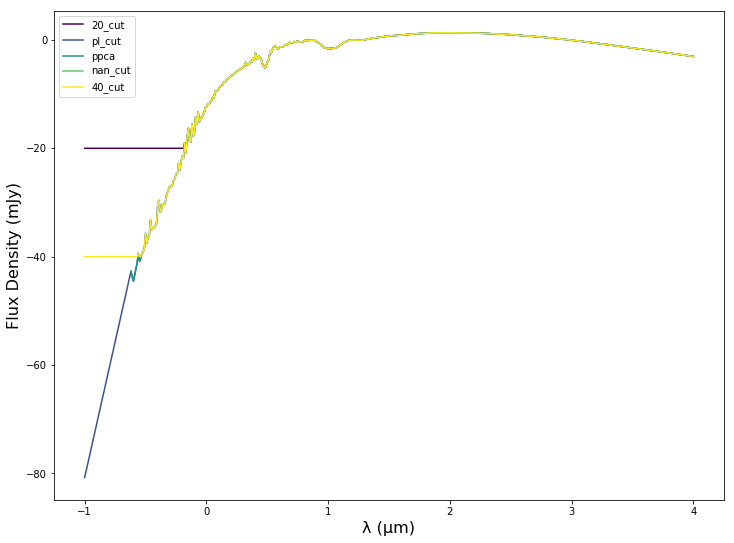

In [11]:
for i in range(50):
    if -np.inf in cube[i]:
        fig,ax=plt.subplots(1,figsize=(12,9))
        for j in range(len(cubes)):
            ax.plot(np.log10(xvals), cubes[j][i],c=colors[j],label=labels[j])
        plt.legend()
        plt.ylabel("Flux Density (mJy)",fontsize=16)
        plt.xlabel("λ (μm)",fontsize=16)
        plt.show()

### subtract sample means to normalize data

In [12]:
# subtracting from the seds each sample mean
seds_msubs=[]

for i in range(len(cubes)):
    seds_msubs.append(cubes[i] - np.nanmean(cubes[3],axis=1)[:,np.newaxis])


### run PCA on mean-subtracted SEDs, horizontal and powerlaw cutoff

In [13]:
t0 = time()

pcacomp1=[]
pcacomp2=[]
pcacomp3=[]

ppca1=PPCA()
ppca1.fit(data=seds_msubs[2],d=40,verbose=False)
ppca2=PPCA()
ppca2.fit(data=seds_msubs[3],d=40,verbose=False)

pcas=[pcacomp1,pcacomp2,ppca1,ppca2,pcacomp3]

for i in (0,1,4):
    pcas[i] = PCA(n_components=40).fit(seds_msubs[i])
    
print("done in %0.3fs" % (time() - t0))

done in 31.471s


In [14]:
pfms=[pcas[0].mean_,pcas[1].mean_,np.nanmean(seds_msubs[2],axis=0),np.nanmean(seds_msubs[3],axis=0),pcas[4].mean_]

In [15]:
# pfm = np.mean(seds_msubs[2],axis=0)
# ppca.var_exp
# eigenseds = np.array([*zip(*ppca.C)])
# coeffs=ppca.transform(seds_msubs[2][model].reshape(1,-1))

### get eigenSEDs

In [67]:
eigensedscomp1=[]
eigensedscomp2=[]
eigensedscomp3=np.array([*zip(*ppca1.C)])
eigensedscomp4=np.array([*zip(*ppca2.C)])
eigensedscomp5=[]

eigenseds=[eigensedscomp1,eigensedscomp2,eigensedscomp3, eigensedscomp4,eigensedscomp5]

for i in (0,1,4):
    eigenseds[i]=np.array(pcas[i].components_)
    eigenseds=np.array(eigenseds)

In [68]:
eigenseds[3].shape

(6, 500)

### look at eigenSEDs

In [69]:
def show_SED(fluxvals):
    fig,ax=plt.subplots(1,figsize=(12,9))
    ax.plot(np.log10(xvals), fluxvals)
    #ax.set_ylim(-6,5)
    plt.ylabel("log of Flux Density (mJy)",fontsize=16)
    plt.xlabel("log of λ (μm)",fontsize=16)
    plt.show()

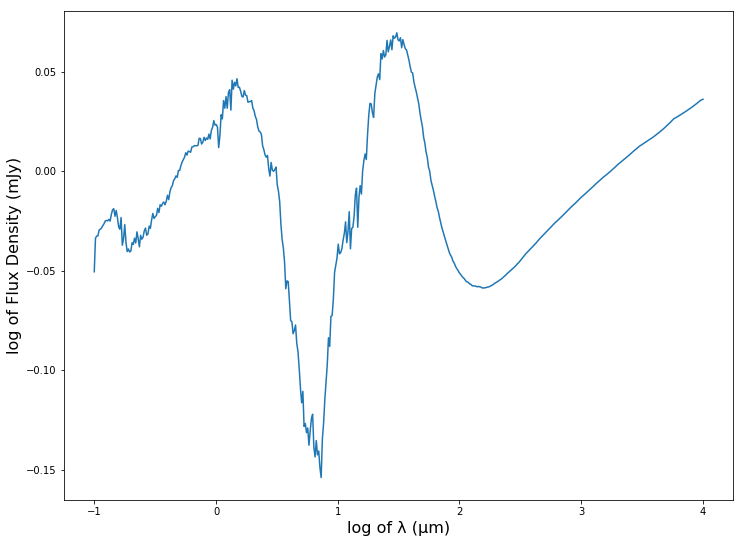

In [70]:
show_SED(eigenseds[3][5])

### variance explained

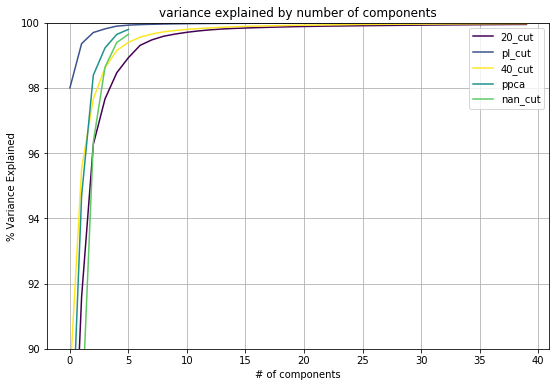

In [71]:
fig,ax=plt.subplots(1,figsize=(9,6))
plt.ylabel('% Variance Explained')
plt.xlabel('# of components')
plt.title('variance explained by number of components')
#plt.ylim(95,100.)
plt.style.context('seaborn-whitegrid')
for i in (0,1,4):
    ax.plot(np.cumsum(pcas[i].explained_variance_ratio_)*100,label=labels[i],c=colors[i])
ax.plot(ppca1.var_exp*100,label=labels[2],c=colors[2])
ax.plot(ppca2.var_exp*100,label=labels[3],c=colors[3])
plt.ylim(90,100)
plt.legend()
plt.grid()
plt.show()

### compare log-spaced SEDs reconstructed with increasing number of components against pdspy SED

In [86]:
def sedcomp(model,ds,ncomp=40, nfeat=500):
    fig,ax=plt.subplots(1,figsize=(12,9))
    coeffs=pcas[ds].transform(seds_msubs[ds][model].reshape(1,-1))
    reconst=np.dot(coeffs[0][0:ncomp+1],eigenseds[ds][0:ncomp+1,0:nfeat]) \
            +pfms[ds][0:nfeat]+np.nanmean(cubes[3][model])    
    ax.plot(np.log10(xvals)[0:nfeat], reconst, c='b',label="reconstructed SED, ncomp="+str(ncomp+1))
    ax.plot(np.log10(xvals)[0:nfeat], cubes[2][model][0:nfeat], c='black',label="pdspy SED")
    plt.legend()
    if -np.inf in cube[model]:
        plt.ylim(-45,10)
    plt.title("reconstructed SED of "+labels[ds]+" model #"+str(model)+" against pdspy SED")
    plt.ylabel("log of Flux Density (mJy)",fontsize=16)
    plt.xlabel("log of λ (μm)",fontsize=16)
    plt.show()

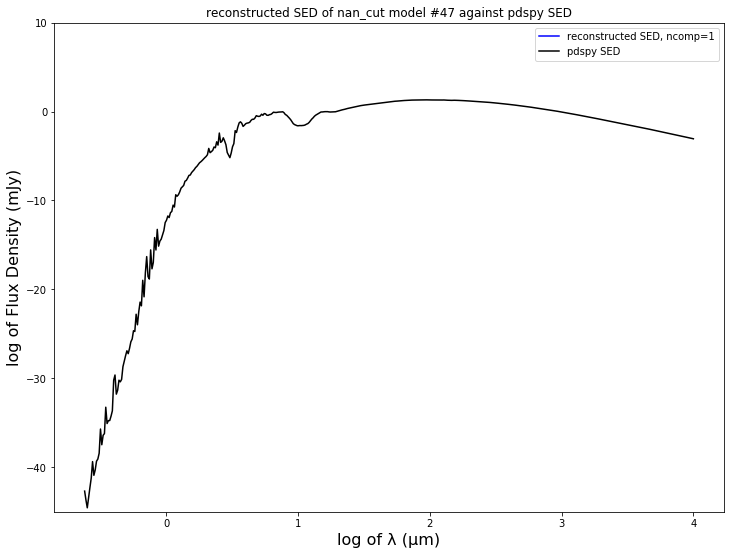

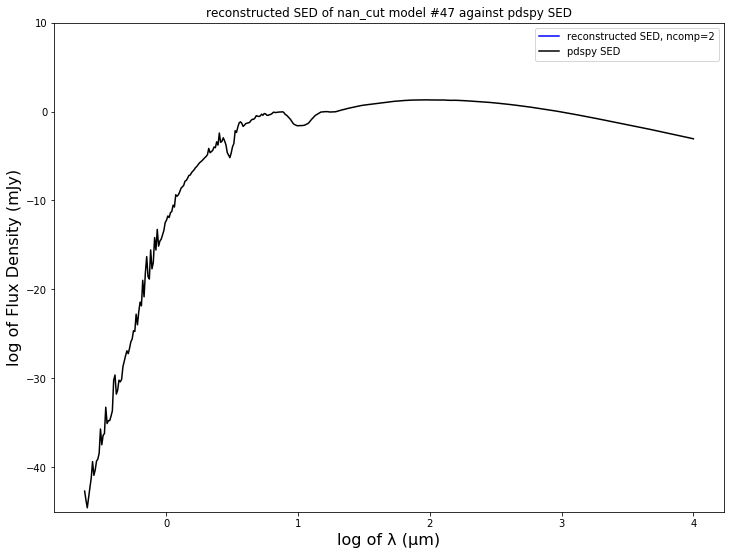

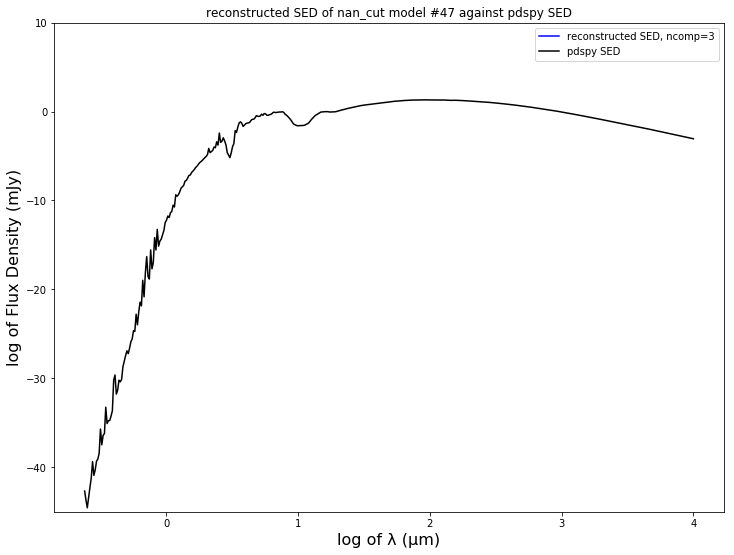

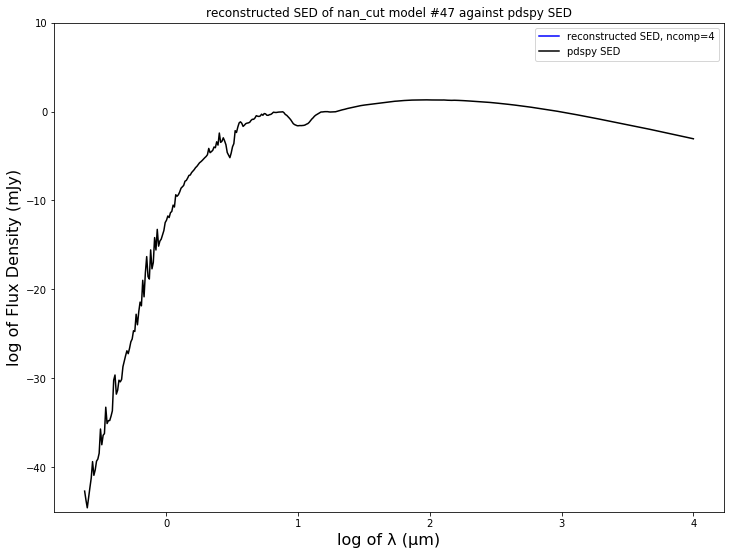

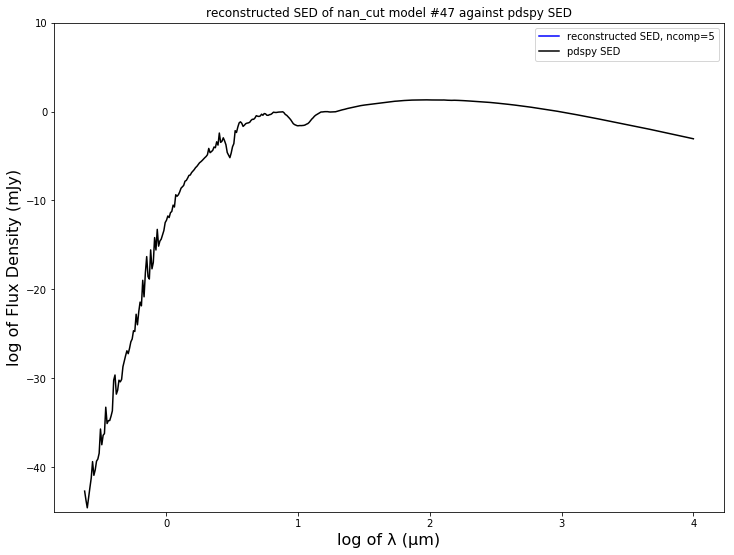

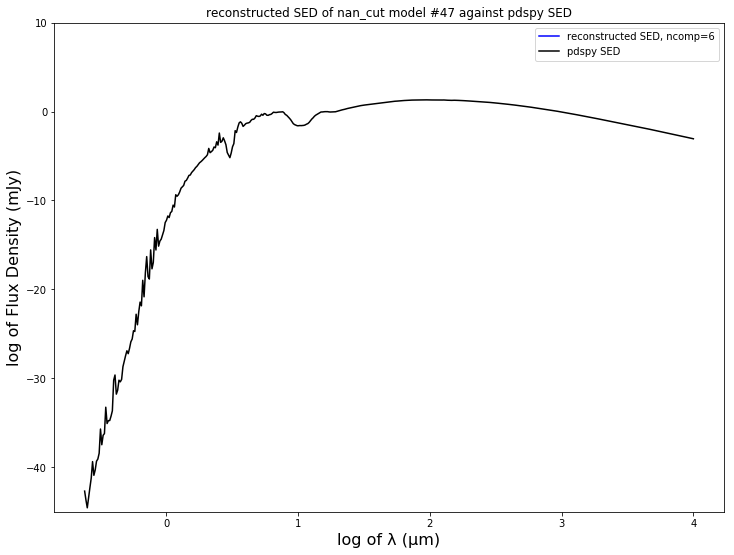

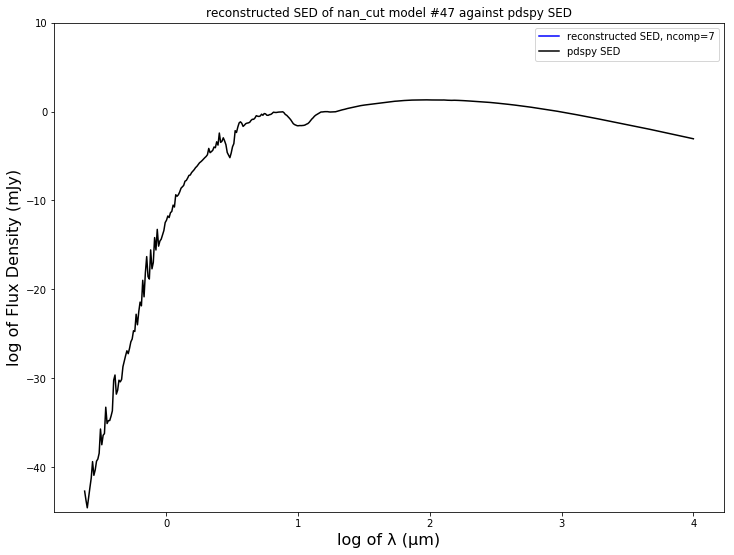

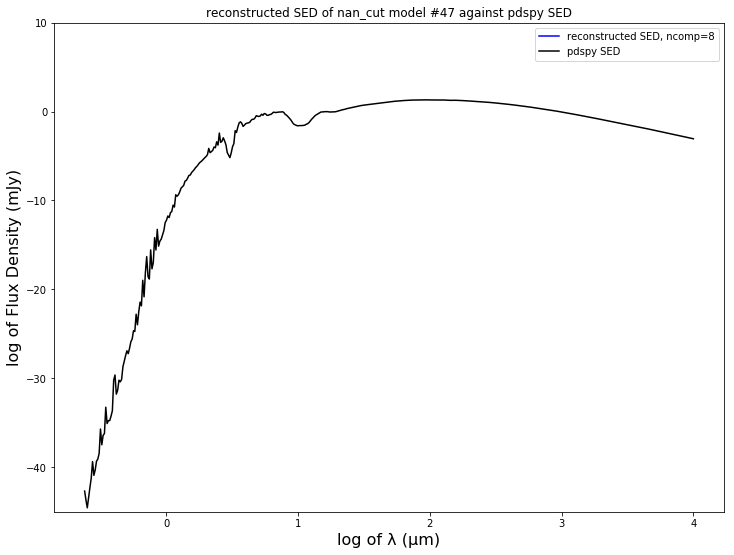

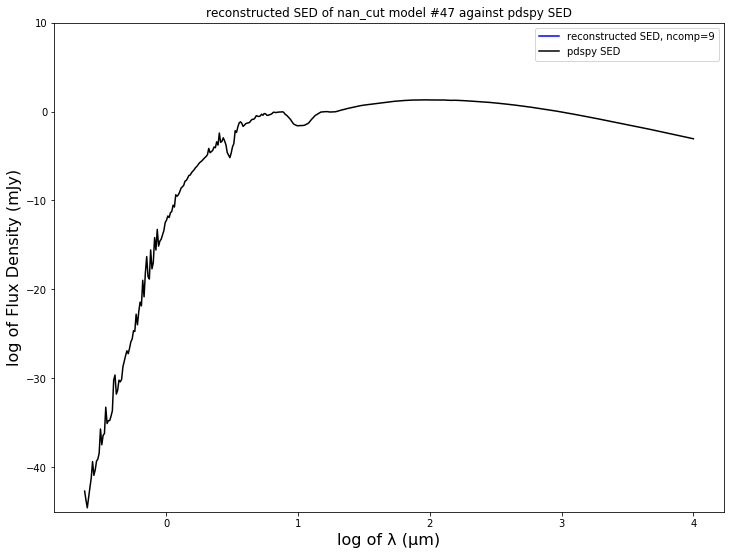

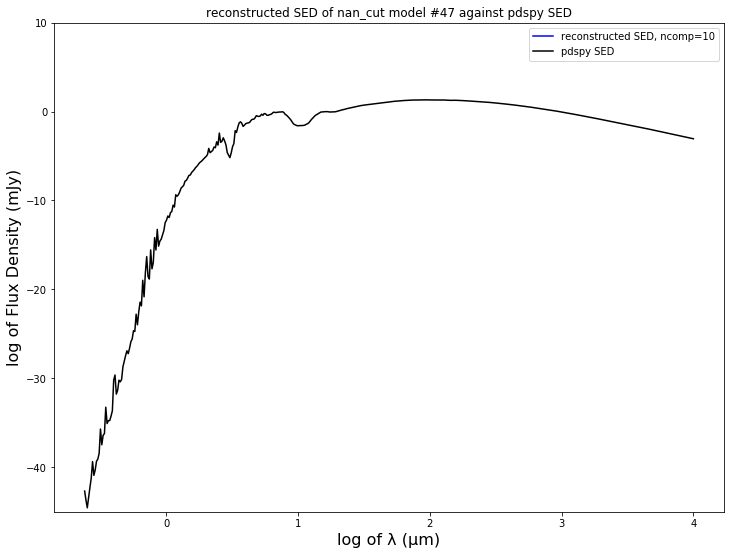

In [91]:
for m in range(10):
    sedcomp(model=47,ds=3,ncomp=m)

In [77]:
def sedcomp_anim(model,ds,ncomp=40,nfeat=500):
    
    fig,ax= plt.subplots(figsize=(12,9))
    ax.plot(np.log10(xvals)[0:nfeat], cubes[2][model][0:nfeat], c='black',label="pdspy SED")
        
    coeffs=pcas[ds].transform(seds_msubs[ds][model].reshape(1,-1)) 
    reconst=[]
    for j in range(ncomp):
        reconst.append(np.dot(coeffs[0][0:j+1],eigenseds[ds][0:j+1,0:nfeat]) +\
                       pfms[ds][0:nfeat]+np.nanmean(cubes[3][model]))
    
    line, = ax.plot(np.log10(xvals)[0:nfeat], reconst[0], c='b')
    
    def animate(i):
        label="number of components = {0}".format(int(i//1))
        line.set_ydata(reconst[int(i//1)])
        ax.set_xlabel("log of λ (μm)",fontsize=16)
        if -np.inf in cube[model]:
            ax.set_ylim(-45,10)
        ax.set_ylabel("log of Flux Density (mJy)",fontsize=16)
        ax.set_title("reconstructed SED of "+labels[ds]+" model #"+str(model)+" against pdspy SED, ncomp="+str(int(i//1)+1))
        return line,ax

    anim=FuncAnimation(fig,animate,frames=np.arange(0,ncomp,0.25),interval=1)
    anim.save("../visualization/comp_cutoff/sedcomp_"+labels[ds]+"_m"+str(model)+"_nc"+str(ncomp)+".gif", dpi=72, writer="imagemagick")

In [ ]:
sedcomp_anim(6,2,ncomp=6)

In [94]:
def multi_sedcomp_anim(model,ncomp=40,nfeat=500):
    
    for ds in range(len(cubes)):
        
        fig,ax= plt.subplots(figsize=(12,9))
        ax.plot(np.log10(xvals)[0:nfeat], cubes[2][model][0:nfeat], c='black',label="pdspy SED")

        coeffs=pcas[ds].transform(seds_msubs[ds][model].reshape(1,-1)) 
        reconst=[]
        for j in range(ncomp):
            reconst.append(np.dot(coeffs[0][0:j+1],eigenseds[ds][0:j+1,0:nfeat]) +\
                           pfms[ds][0:nfeat]+np.nanmean(cubes[3][model]))

        line, = ax.plot(np.log10(xvals)[0:nfeat], reconst[0], c='b')

        def animate(i):
            label="number of components = {0}".format(int(i//1))
            line.set_ydata(reconst[int(i//1)])
            ax.set_xlabel("log of λ (μm)",fontsize=16)
            if -np.inf in cube[model]:
                ax.set_ylim(-45,10)
            ax.set_ylabel("log of Flux Density (mJy)",fontsize=16)
            ax.set_title("reconstructed SED of "+labels[ds]+" model #"+str(model)+" against pdspy SED, ncomp="+str(int(i//1)+1))
            return line,ax
        print("done with "+labels[ds]+" model")

        anim=FuncAnimation(fig,animate,frames=np.arange(0,ncomp,0.25),interval=1)
        anim.save("../visualization/comp_cutoff/sedcomp_"+labels[ds]+"_m"+str(model)+"_nc"+str(ncomp)+".gif", dpi=72, writer="imagemagick")

done with 20_cut model
done with pl_cut model
done with ppca model
done with nan_cut model
done with 40_cut model
done with 20_cut model
done with pl_cut model
done with ppca model
done with nan_cut model
done with 40_cut model


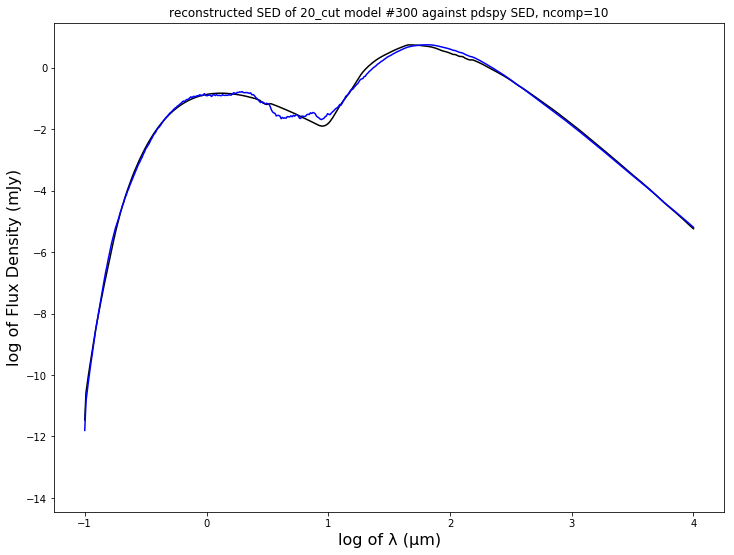

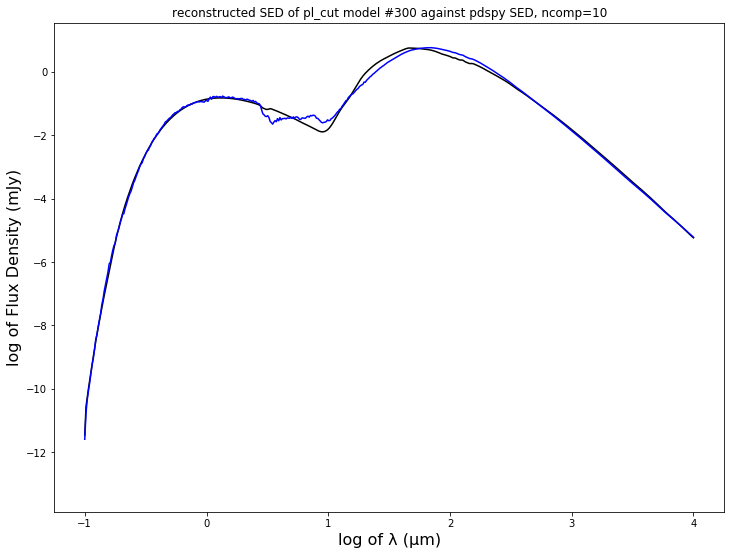

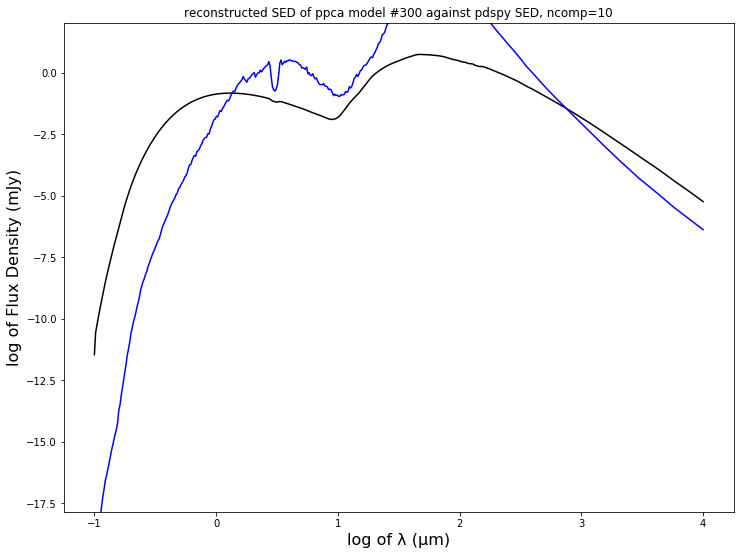

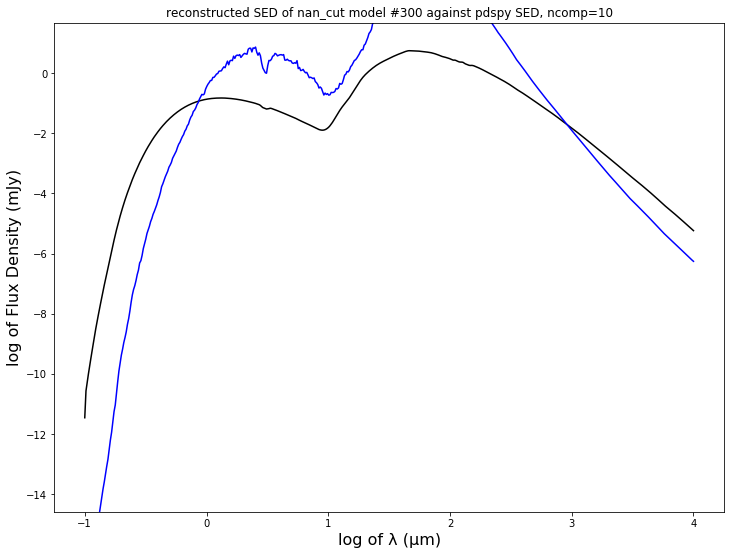

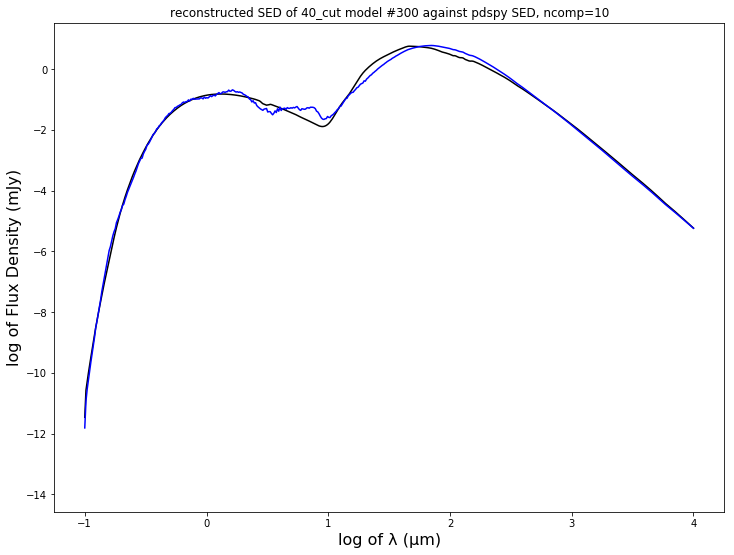

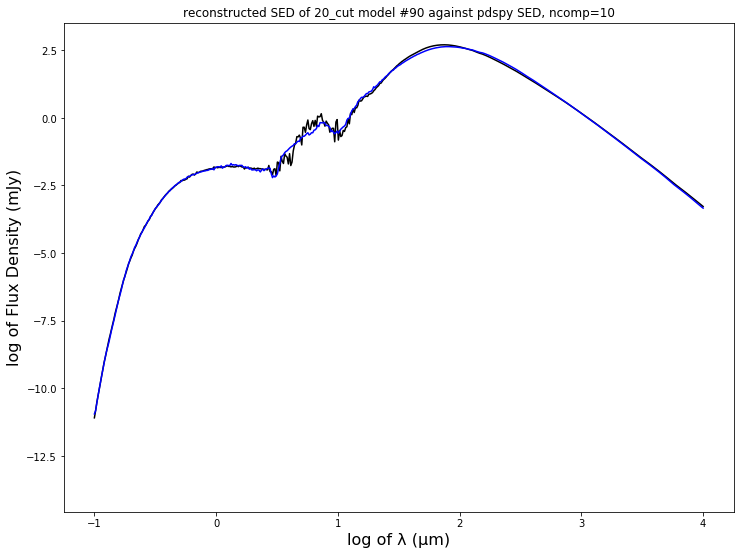

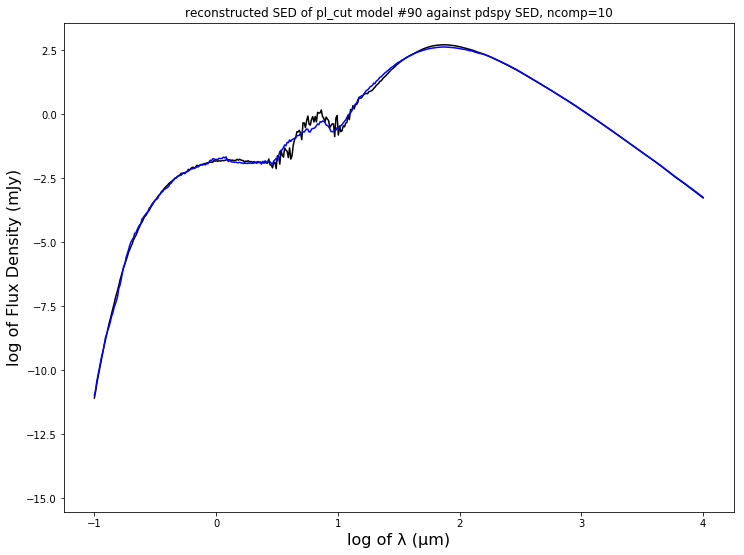

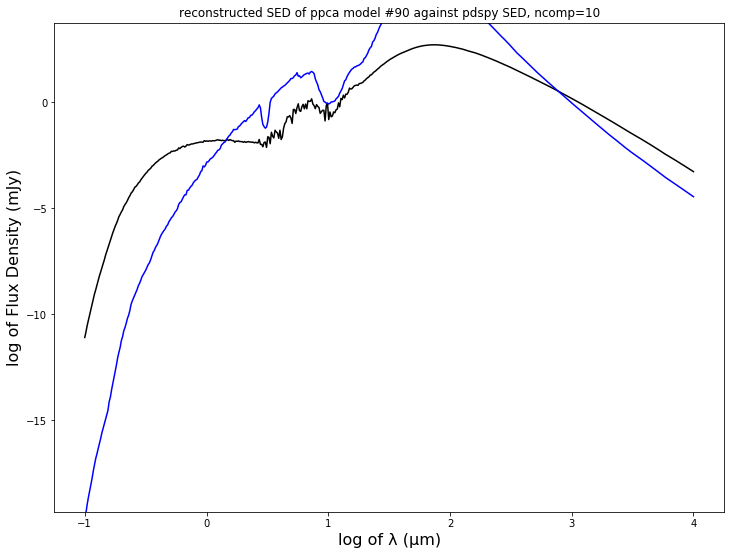

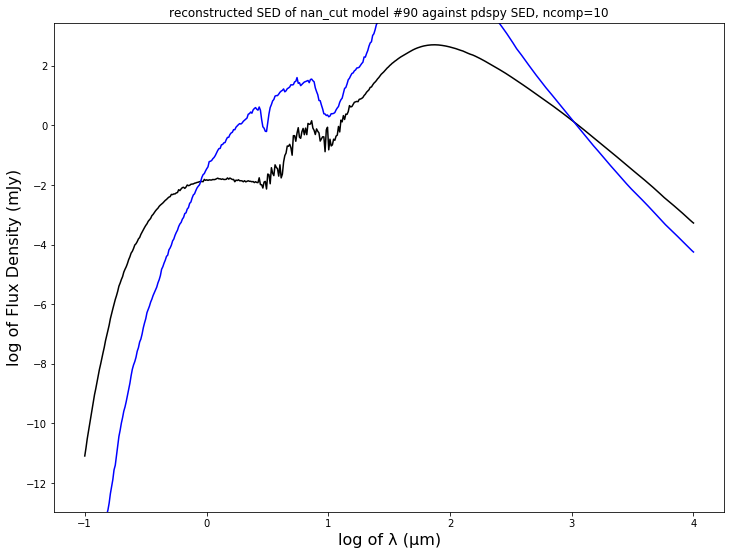

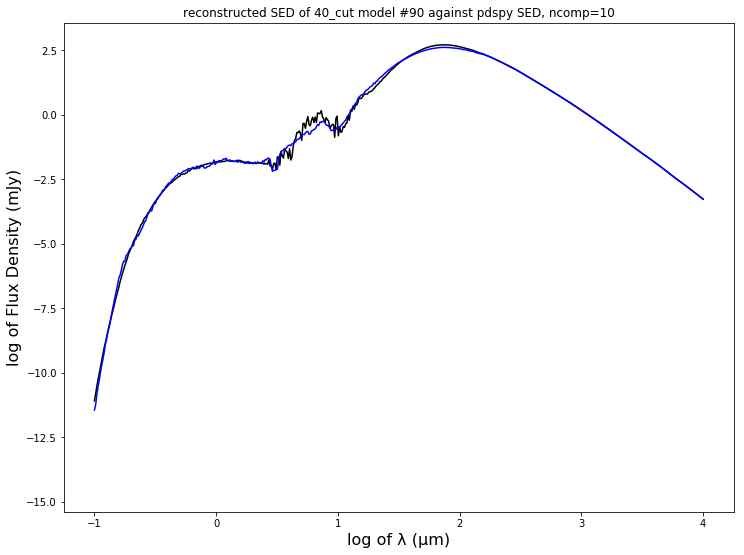

In [95]:
multi_sedcomp_anim(300,ncomp=10)
multi_sedcomp_anim(90,ncomp=10)

### compare log-spaced residuals of SEDs reconstructed with increasing number of components

In [ ]:
def residcomp(model,ds,ncomp=40,nfeat=500):
    
    interval=np.linspace(0.1,1.,ncomp)
    colors= plt.cm.viridis(interval)
    
    fig,ax=plt.subplots(1,figsize=(12,9))
    
    for m in range(ncomp):
        coeffs=pcas[ds].transform(seds_msubs[ds][i].reshape(1,-1))
        reconst=np.dot(coeffs[0][0:m+1],eigenseds[ds][0:m+1,0:nfeat]) \
                +pfms[ds][0:nfeat]+np.nanmean(cubes[3][model])
        resids = reconst-(cubes[ds][i][0:nfeat]) # log flux space residuals
        # resids = 10**reconst-10**(cubes[ds][i][0:nfeat]) # normal flux space residuals
        ax.plot(np.log10(xvals)[0:nfeat],resids, c=colors[m],label="ncomp="+str(m+1)) 
    plt.legend()
    plt.title("log-space residuals of reconst. SEDs of "+labels[ds]+" model #"+str(i)+\
              ", by number of components")
    plt.ylabel("log of Flux Density (mJy)",fontsize=16)
    plt.xlabel("log of λ (μm)",fontsize=16)
    #plt.ylim(-2,2)
    plt.show()

In [ ]:
residcomp(6,1,ncomp=10)